In [1]:
import os
import sys
import glob
from os.path import abspath
os.environ['SPARK_HOME'] = 'C:\spark-3.1.2-bin-hadoop3.2'
os.environ['JAVA_HOME'] = 'C:\Program Files\Java\jdk1.8.0_201'
os.environ['HADOOP_HOME'] = 'C:\spark-3.1.2-bin-hadoop3.2'
spark_python = os.path.join(os.environ.get('SPARK_HOME',None),'python')
py4j = glob.glob(os.path.join(spark_python,'lib','py4j-*.zip'))[0]
graphf = glob.glob(os.path.join(spark_python,'graphframes.zip'))[0]
sys.path[:0]=[spark_python,py4j]
sys.path[:0]=[spark_python,graphf]
os.environ['PYTHONPATH']=py4j+os.pathsep+graphf
import findspark
findspark.init()
findspark.find()
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("Spark Examples").enableHiveSupport().getOrCreate()

In [2]:
from graphframes import *
import networkx as nx
import matplotlib.pyplot as plt

In [3]:
vertices = spark.createDataFrame([("James", "Software Engineer"),
                                 ("Mary", "Software Engineer"),
                                 ("Roy", "Product Developer"),
                                 ("Ryan", "HR"),
                                 ("John", "Security"),
                                 ("Robert", "Testing Engineer")], ["id", "Designation"])
vertices.show()

+------+-----------------+
|    id|      Designation|
+------+-----------------+
| James|Software Engineer|
|  Mary|Software Engineer|
|   Roy|Product Developer|
|  Ryan|               HR|
|  John|         Security|
|Robert| Testing Engineer|
+------+-----------------+



In [4]:
edges = spark.createDataFrame([("James", "Mary", "colleagues"),
                              ("Mary", "James", "colleagues"),
                              ("Roy", "James", "friends"),
                              ("James", "Roy", "friends"),
                              ("Mary", "Roy", "neighbours"),
                              ("Roy", "Mary", "neighbours"),
                              ("Roy", "Ryan", "friends"),
                              ("Ryan", "Roy", "friends"),
                              ("James", "Ryan", "friends"),
                              ("Ryan", "James", "friends"),
                              ("John", "Roy", "friends"),
                              ("Roy", "John", "friends"),
                              ("Ryan", "John", "reportsto"),
                              ("Robert", "John", "reportsto")],
                             ["src", "dst", "type"])

In [5]:
edges.show()

+------+-----+----------+
|   src|  dst|      type|
+------+-----+----------+
| James| Mary|colleagues|
|  Mary|James|colleagues|
|   Roy|James|   friends|
| James|  Roy|   friends|
|  Mary|  Roy|neighbours|
|   Roy| Mary|neighbours|
|   Roy| Ryan|   friends|
|  Ryan|  Roy|   friends|
| James| Ryan|   friends|
|  Ryan|James|   friends|
|  John|  Roy|   friends|
|   Roy| John|   friends|
|  Ryan| John| reportsto|
|Robert| John| reportsto|
+------+-----+----------+



In [6]:
vertices.count()

6

In [7]:
edges.count()

14

In [8]:
g = GraphFrame(vertices, edges)

In [13]:
# the function will plot the source and destination nodes and connect them by meand of undirected line
def plot_directed_graph(edge_list):
    plt.figure(figsize=(9,9))
    gplot=nx.DiGraph()
    edge_labels = {}
    for row in edge_list.select("src", "dst", "type").take(1000):
        gplot.add_edge(row["src"], row["dst"])
        edge_labels[(row["src"], row["dst"])] = row["type"]
    pos = nx.spring_layout(gplot)
    nx.draw(gplot, pos, with_labels=True, font_weight="bold", node_size=3500)
    nx.draw_networkx_edge_labels(gplot, pos, edge_labels=edge_labels, font_color="green", font_size=11, font_weight="bold")

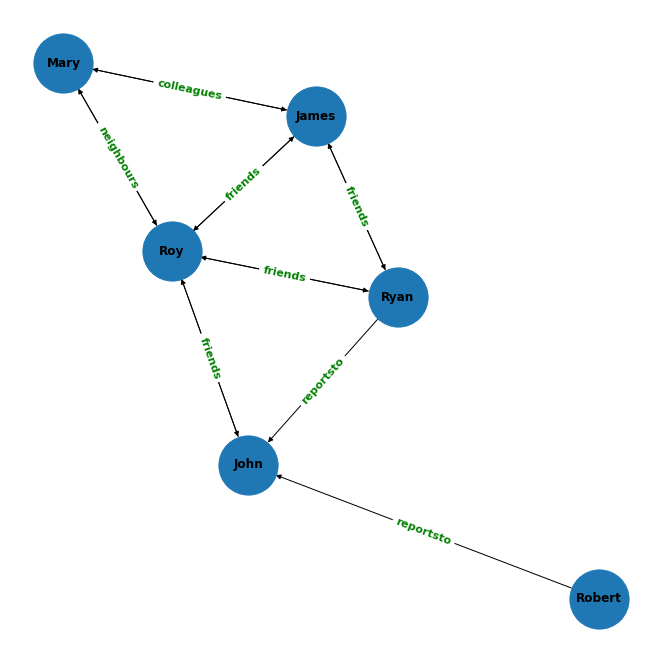

In [15]:
plot_directed_graph(g.edges)

In [21]:
simple_motifs = g.find("(start_vertex)-[edge]->(end_vertex)")
simple_motifs.show(truncate=False)
simple_motifs.count()

+--------------------------+-------------------------+--------------------------+
|start_vertex              |edge                     |end_vertex                |
+--------------------------+-------------------------+--------------------------+
|{James, Software Engineer}|{James, Mary, colleagues}|{Mary, Software Engineer} |
|{Roy, Product Developer}  |{Roy, Mary, neighbours}  |{Mary, Software Engineer} |
|{Mary, Software Engineer} |{Mary, James, colleagues}|{James, Software Engineer}|
|{Roy, Product Developer}  |{Roy, James, friends}    |{James, Software Engineer}|
|{Ryan, HR}                |{Ryan, James, friends}   |{James, Software Engineer}|
|{Mary, Software Engineer} |{Mary, Roy, neighbours}  |{Roy, Product Developer}  |
|{James, Software Engineer}|{James, Roy, friends}    |{Roy, Product Developer}  |
|{John, Security}          |{John, Roy, friends}     |{Roy, Product Developer}  |
|{Ryan, HR}                |{Ryan, Roy, friends}     |{Roy, Product Developer}  |
|{Roy, Product D

14

In [24]:
filtered_motifs = g.find("(start_vertex)-[edge]->(end_vertex)").filter("edge.type='friends'")
filtered_motifs.show(truncate=False)
filtered_motifs.count()

+--------------------------+----------------------+--------------------------+
|start_vertex              |edge                  |end_vertex                |
+--------------------------+----------------------+--------------------------+
|{Roy, Product Developer}  |{Roy, James, friends} |{James, Software Engineer}|
|{Ryan, HR}                |{Ryan, James, friends}|{James, Software Engineer}|
|{James, Software Engineer}|{James, Roy, friends} |{Roy, Product Developer}  |
|{John, Security}          |{John, Roy, friends}  |{Roy, Product Developer}  |
|{Ryan, HR}                |{Ryan, Roy, friends}  |{Roy, Product Developer}  |
|{Roy, Product Developer}  |{Roy, John, friends}  |{John, Security}          |
|{James, Software Engineer}|{James, Ryan, friends}|{Ryan, HR}                |
|{Roy, Product Developer}  |{Roy, Ryan, friends}  |{Ryan, HR}                |
+--------------------------+----------------------+--------------------------+



8

In [25]:
filtered_motifs = g.find("(start_vertex)-[edge]->(end_vertex)")\
                    .filter("start_vertex.id='Roy' AND edge.type='friends'")
filtered_motifs.show(truncate=False)
filtered_motifs.count()

+------------------------+---------------------+--------------------------+
|start_vertex            |edge                 |end_vertex                |
+------------------------+---------------------+--------------------------+
|{Roy, Product Developer}|{Roy, James, friends}|{James, Software Engineer}|
|{Roy, Product Developer}|{Roy, John, friends} |{John, Security}          |
|{Roy, Product Developer}|{Roy, Ryan, friends} |{Ryan, HR}                |
+------------------------+---------------------+--------------------------+



3

In [28]:
filtered_motifs.select("start_vertex.id", "edge.type", "end_vertex.id").show(truncate=False)

+---+-------+-----+
|id |type   |id   |
+---+-------+-----+
|Roy|friends|James|
|Roy|friends|John |
|Roy|friends|Ryan |
+---+-------+-----+

